#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/mini_project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
#변수중요도 뽑을 랜덤 포레스트 모델 관련 함수
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [6]:
data = pd.read_csv(path + 'data01_train.csv')
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [7]:
data_t = pd.read_csv(path + 'data01_test.csv')
data_t.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING


In [8]:
data = data.drop(columns='subject')
data_t = data_t.drop(columns='subject')

In [9]:
features = pd.read_csv(path + 'features.csv')
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


#### 2) 기본 정보 조회

In [10]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [11]:
data.isna().sum()

,0
tBodyAcc-mean()-X,0
tBodyAcc-mean()-Y,0
tBodyAcc-mean()-Z,0
tBodyAcc-std()-X,0
tBodyAcc-std()-Y,0
...,...
"angle(tBodyGyroJerkMean,gravityMean)",0
"angle(X,gravityMean)",0
"angle(Y,gravityMean)",0
"angle(Z,gravityMean)",0


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [12]:
# 기존 'Activity' 컬럼을 기준으로 정적 행동과 동적 행동을 구분하는 새로운 레이블을 생성합니다.
static_actions = ['STANDING', 'SITTING', 'LAYING']
dynamic_actions = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

# 새로운 레이블 생성: 0은 정적 행동, 1은 동적 행동
data['is_dynamic'] = data['Activity'].apply(lambda x: 0 if x in static_actions else 1)

# 새롭게 생성된 데이터 확인
data[['Activity', 'is_dynamic']].head()

,Activity,is_dynamic
0,STANDING,0
1,LAYING,0
2,STANDING,0
3,WALKING,1
4,WALKING_DOWNSTAIRS,1


### (1) 정적 데이터 상위 특징 추출

In [13]:
static_data = data[data['is_dynamic'] == 0]
static_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING,0


In [14]:
x_static = static_data.drop(columns=['Activity', 'is_dynamic'])
y_static = static_data['Activity']

In [15]:
x_static_scaled = MinMaxScaler().fit_transform(x_static)

In [16]:
x_static_train, x_static_val, y_static_train, y_static_val = train_test_split(x_static_scaled, y_static, test_size=0.3, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 모델 생성 및 학습
rf_model_static = RandomForestClassifier(random_state=42)
rf_model_static.fit(x_static_train, y_static_train)

RandomForestClassifier(random_state=42)

In [18]:
# 변수 중요도 계산 후 시각화
# X_train과 feature_importances는 모델 학습 과정에서 얻은 결과입니다
feature_names = x_static.columns
feature_importances = rf_model_static.feature_importances_

# 변수 중요도를 얻어오기
df_static = plot_feature_importance(feature_importances, feature_names, result_only=True)
df_static #정적 상위 피쳐
sorted_static_features = df_static['feature_name'].tolist()

In [19]:
sorted_static_features[:5]

['tGravityAcc-mean()-X',
 'tGravityAcc-mean()-Y',
 'angle(X,gravityMean)',
 'tGravityAcc-max()-X',
 'angle(Z,gravityMean)']

### (2) 동적 데이터 상위 특징 추출

In [20]:
dynamic_data = data[data['is_dynamic'] == 1]
dynamic_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,WALKING,1


In [21]:
X = dynamic_data.drop(columns=['Activity', 'is_dynamic'])
y = dynamic_data['Activity']

In [22]:
# Min-Max 스케일러 객체 생성
scaler = MinMaxScaler()

# X 데이터에 스케일러 적용
X_scaled = scaler.fit_transform(X)

In [23]:
# train:val 비율을 7:3으로 설정 (test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [24]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# 변수 중요도 계산 후 시각화
# X_train과 feature_importances는 모델 학습 과정에서 얻은 결과입니다
feature_names = X.columns
feature_importances = rf_model.feature_importances_

# 변수 중요도를 얻어오기
fi_df = plot_feature_importance(feature_importances, feature_names, result_only=True)
fi_df #동적 상위 피쳐
sorted_dynamic_features = fi_df['feature_name'].tolist()

In [26]:
from sklearn.metrics import *

y_pred = rf_model.predict(X_val)

# 모델 평가
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.979874213836478
[[281   4   2]
 [  4 236   1]
 [  2   3 262]]
                    precision    recall  f1-score   support

           WALKING       0.98      0.98      0.98       287
WALKING_DOWNSTAIRS       0.97      0.98      0.98       241
  WALKING_UPSTAIRS       0.99      0.98      0.98       267

          accuracy                           0.98       795
         macro avg       0.98      0.98      0.98       795
      weighted avg       0.98      0.98      0.98       795



In [27]:
sorted_dynamic_features[:5]

['tBodyAccMag-std()',
 'tGravityAcc-arCoeff()-Z,2',
 'tGravityAccMag-std()',
 'fBodyAccMag-energy()',
 'tGravityAcc-arCoeff()-Y,1']

### (1) 1단계 모델링을 위한 레이블

In [28]:
# 정적/동적 데이터 row만 뽑아서 반환
def data_to(data, Is_static=True):
  data['is_dynamic'] = data['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                                             'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
  if Is_static:
    data_changed = data.loc[data['is_dynamic'] == 0].copy()
  else:
    data_changed = data.loc[data['is_dynamic'] == 1].copy()

  drop_cols = ['is_dynamic']

  data_changed.drop(columns=drop_cols, inplace=True)

  return data_changed

In [29]:
# 입력 데이터 전처리
# selected_cols로 특정 features 타겟팅
def data_pipe(target, data, encoder=LabelEncoder(), selected_cols=[]):
  if len(selected_cols) > 0:
    x = data[selected_cols]
  else:
    x = data.drop(columns=[target])
  y = data[target]

  x_s = MinMaxScaler().fit_transform(x)

  encoded_y = pd.DataFrame()
  encoded_y[target] = encoder.fit_transform(y)

  return x_s, encoded_y

In [ ]:
# data['is_dynamic'] = data['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
#                                                        'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})

# data[['Activity', 'is_dynamic']].head()

,Activity,is_dynamic
0,STANDING,0
1,LAYING,0
2,STANDING,0
3,WALKING,1
4,WALKING_DOWNSTAIRS,1


In [ ]:
# data = pd.get_dummies(data, columns=['Activity'])
# data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",is_dynamic,Activity_LAYING,Activity_SITTING,Activity_STANDING,Activity_WALKING,Activity_WALKING_DOWNSTAIRS,Activity_WALKING_UPSTAIRS
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.601120,0.331298,0.165163,0,False,False,True,False,False,False
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.345205,-0.769186,-0.147944,0,True,False,False,False,False,False
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.833564,0.202434,-0.032755,0,False,False,True,False,False,False
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.695819,0.287154,0.111388,1,False,False,False,True,False,False
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.705029,0.264952,0.137758,1,False,False,False,False,True,False


### (2) x, y 분리

In [ ]:
# target = 'is_dynamic'

# x = data.drop(columns=target)
# y = data.loc[:, target]

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
# # Min-Max 스케일러 객체 생성
# scaler = MinMaxScaler()

# # X 데이터에 스케일러 적용
# X_scaled = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [78]:
target = 'Activity'

In [79]:
data_train_static = data_to(data, Is_static=True)
data_train_dynamic = data_to(data, Is_static=False)

In [80]:
data_test_static = data_to(data_t, Is_static=True)
data_test_dynamic = data_to(data_t, Is_static=False)

In [81]:
# f가 붙은건 상위 features columns를 뽑은 데이터
x, y = data_pipe(target, data)
x_static, y_static = data_pipe(target, data_train_static)
x_dynamic, y_dynamic = data_pipe(target, data_train_dynamic)
x_test_static, y_test_static = data_pipe(target, data_test_static)
x_test_dynamic, y_test_dynamic = data_pipe(target, data_test_dynamic)
x_static_f, y_static_f = data_pipe(target, data_train_static, selected_cols=sorted_static_features[:150])
x_dynamic_f, y_dynamic_f = data_pipe(target, data_train_dynamic, selected_cols=sorted_static_features[:150])
x_test_static_f, y_test_static_f = data_pipe(target, data_test_static, selected_cols=sorted_static_features[:150])
x_test_dynamic_f, y_test_dynamic_f = data_pipe(target, data_test_dynamic, selected_cols=sorted_static_features[:150])

In [82]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)
x_train_static, x_val_static, y_train_static, y_val_static = train_test_split(x_static, y_static, test_size=0.3, random_state=42)
x_train_dynamic, x_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(x_dynamic, y_dynamic, test_size=0.3, random_state=42)

In [83]:
x_train_static_f, x_val_static_f, y_train_static_f, y_val_static_f = train_test_split(x_static_f, y_static_f, test_size=0.3, random_state=42)
x_train_dynamic_f, x_val_dynamic_f, y_train_dynamic_f, y_val_dynamic_f = train_test_split(x_dynamic_f, y_dynamic_f, test_size=0.3, random_state=42)

In [84]:
x_train_static_f.shape

(2263, 150)

In [85]:
x_train_static.shape

(2263, 561)

## **3.단계별 모델링**

### (1) 단계1

* **굵은 텍스트** 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [38]:
# 정적 / 동적 분리 모델 전처리
tmp_data = data.copy()

target = 'is_dynamic'

tmp_data[target] = tmp_data['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                                             'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})

x = tmp_data.drop(columns=[target, 'Activity'])
y = tmp_data[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

#### 1) 모델1

In [39]:
nfeatures = x_train.shape[1]
nfeatures

561

In [40]:
x_train.shape

(4116, 561)

In [41]:
clear_session()

model1 = Sequential([Input(shape = (nfeatures,)),
                     Dense(200, activation='relu'),
                     Dense(50, activation='relu'),
                     Dense(1, activation='sigmoid')])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 200)                 │         112,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
hist1 = model1.fit(x_train, y_train, epochs=100, validation_split=.2, verbose=0)

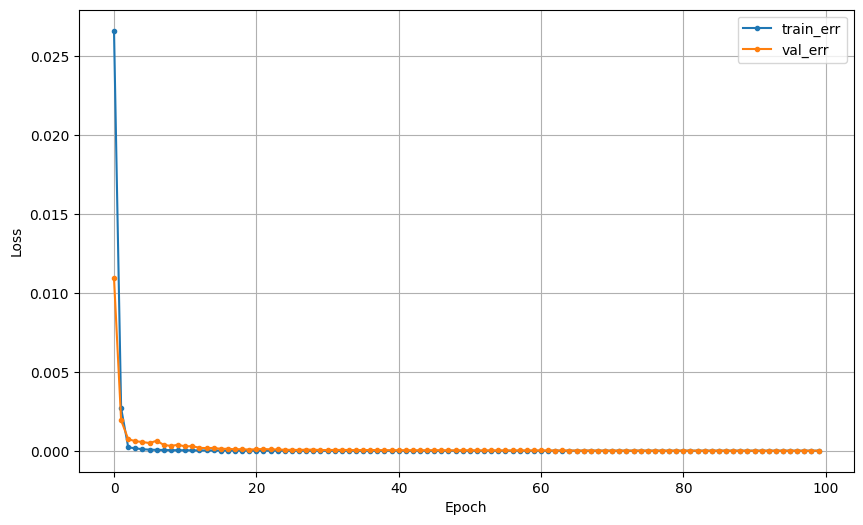

In [43]:
dl_history_plot(hist1.history)

In [44]:
pred = model1.predict(x_val)
pred = np.where(pred > 0.5, 1, 0)

print(accuracy_score(y_val, pred))
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1.0
[[957   0]
 [  0 808]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       957
           1       1.00      1.00      1.00       808

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [ ]:
# data_t['is_dynamic'] = data_t['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
#                                             'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})

In [ ]:
# data_t = pd.get_dummies(data_t, columns=['Activity'])

In [ ]:
# x_test = data_t.drop(target, axis=1)
# y_test = data_t[target]

In [ ]:
# pred = model1.predict(x_test)
# pred = np.where(pred > 0.5, 1, 0)

# print(accuracy_score(y_test, pred))
# print(confusion_matrix(y_test, pred))
# print(classification_report(y_test, pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1.0
[[833   0]
 [  0 638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



#### 2) 모델2

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [45]:
def estimate(model, x, y, encode='sparse'):
  pred = model.predict(x).argmax(axis=1)

  if encode == 'onehot':
    y = y.argmax(axis=1)

  print()
  print(confusion_matrix(y, pred))
  print()
  print('-'*60)
  print()
  print(classification_report(y, pred))

  return round(accuracy_score(y, pred),4)

In [67]:
def model_compile_fit(model, x_train, y_train, ep = 30, lr = 0.01, callback=[]):
  model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy')

  if len(callback) > 0:
    hist = model.fit(x_train, y_train, epochs=ep, validation_split=0.3, verbose=0, callbacks=callback)
  else:
    hist = model.fit(x_train, y_train, epochs=ep, validation_split=0.3, verbose=0)

  dl_history_plot(hist.history)

  return model

In [68]:
# 하이퍼 파람 튜닝
def hyperparameter_tuning(modeling, x_train, y_train, x_test, y_test, callback=[]):
  epochs = [50, 100, 200]
  learning_rates = [0.01, 0.001, 0.0005]
  max_accuracy = 0
  best_epoch = 0
  best_lr = 0
  model_final = modeling()

  for ep in epochs:
    for lr in learning_rates:
      tmp_model = model_compile_fit(modeling(), x_train, y_train, ep=ep, lr=lr, callback=callback)
      tmp_acc = estimate(tmp_model, x_test, y_test)
      if max_accuracy < tmp_acc:
        max_accuracy = tmp_acc
        best_epoch = ep
        best_lr = lr
        model_final = tmp_model

  return model_final, max_accuracy, best_epoch, best_lr

In [48]:
nfeatures = x_train_static.shape[1]
nfeatures

561

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │           4,496 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,496 (17.56 KB)

 Trainable params: 4,496 (17.56 KB)

 Non-trainable params: 0 (0.00 B)

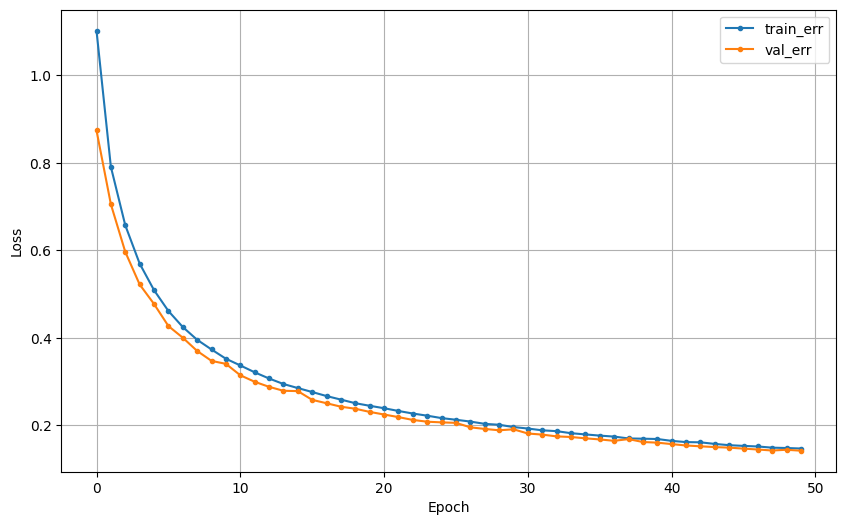

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[292   0   0]
 [  1 223  30]
 [  0  14 273]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.94      0.88      0.91       254
           2       0.90      0.95      0.93       287

    accuracy                           0.95       833
   macro avg       0.95      0.94      0.94       833
weighted avg       0.95      0.95      0.95       833

0.946


In [58]:
# base_static_model
clear_session()

model1_static = Sequential([Input(shape=(nfeatures, )),
                            Dense(8, activation='softmax')
                            ])

model1_static.summary()

model1_static = model_compile_fit(model1_static, ep=50, lr=0.001)

print(estimate(model1_static, x_static_test, y_static_test))

In [61]:
def modeling2():
  clear_session()

  model2_static = Sequential([Input(shape=(nfeatures, )),
                              Dense(128, activation='relu'),
                              Dense(64, activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(16, activation='relu'),
                              Dense(8, activation='softmax')
                              ])
  return model2_static

#model2_static.summary()

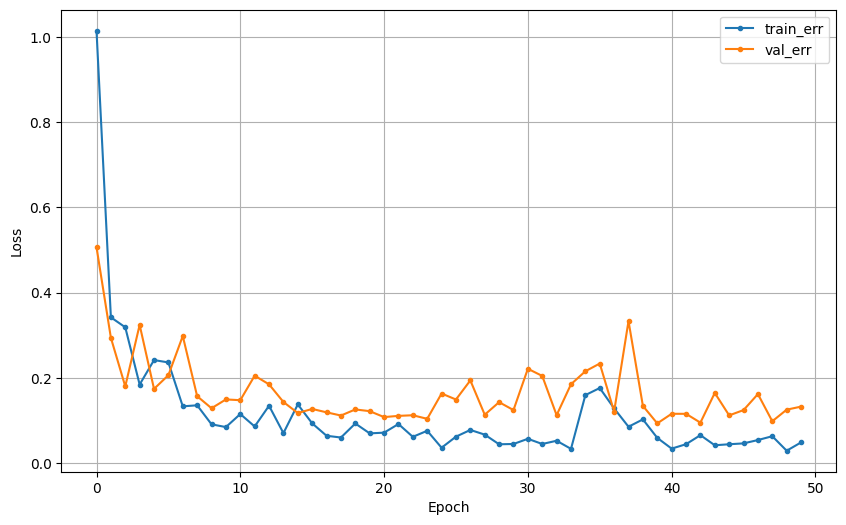

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[292   0   0]
 [  1 237  16]
 [  0  19 268]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.93      0.93      0.93       254
           2       0.94      0.93      0.94       287

    accuracy                           0.96       833
   macro avg       0.96      0.96      0.96       833
weighted avg       0.96      0.96      0.96       833



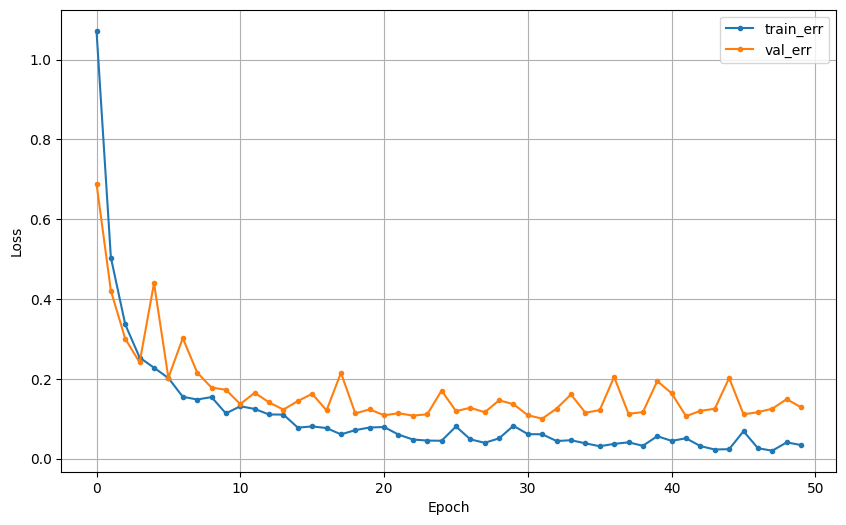

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[289   3   0]
 [  1 216  37]
 [  0  10 277]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.94      0.85      0.89       254
           2       0.88      0.97      0.92       287

    accuracy                           0.94       833
   macro avg       0.94      0.94      0.94       833
weighted avg       0.94      0.94      0.94       833



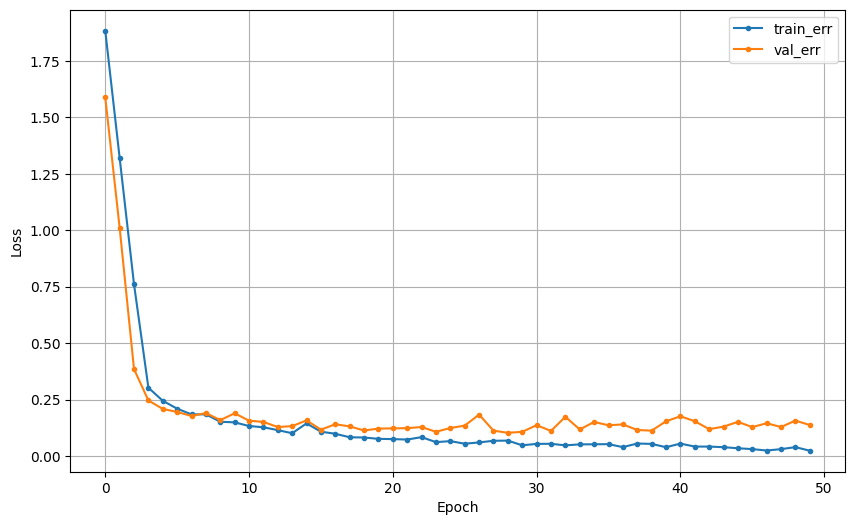

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

[[290   0   2]
 [  1 233  20]
 [  2  12 273]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       292
           1       0.95      0.92      0.93       254
           2       0.93      0.95      0.94       287

    accuracy                           0.96       833
   macro avg       0.96      0.95      0.95       833
weighted avg       0.96      0.96      0.96       833



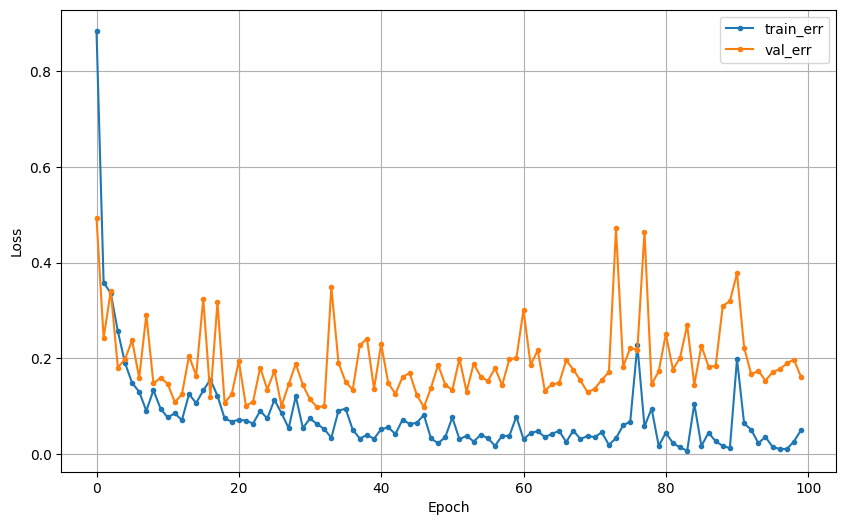

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[292   0   0]
 [  1 237  16]
 [  2  18 267]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.93      0.93      0.93       254
           2       0.94      0.93      0.94       287

    accuracy                           0.96       833
   macro avg       0.95      0.95      0.95       833
weighted avg       0.96      0.96      0.96       833



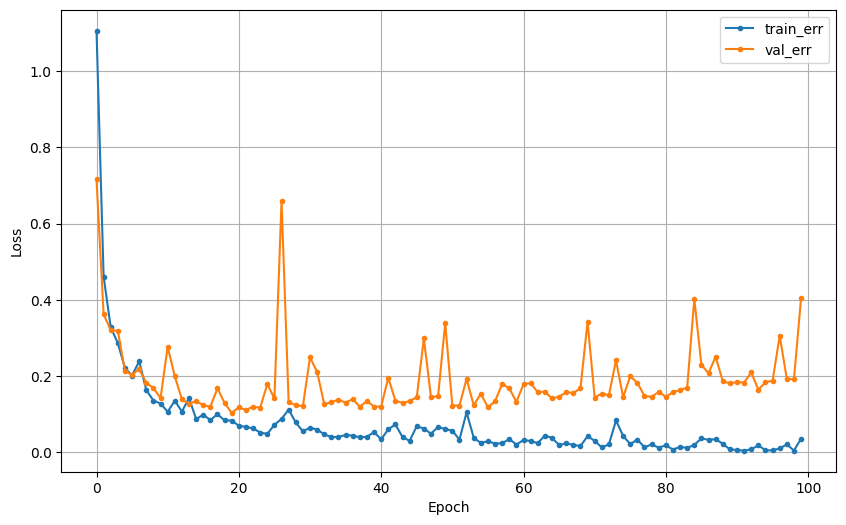

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[289   3   0]
 [  1 239  14]
 [  0  32 255]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.87      0.94      0.91       254
           2       0.95      0.89      0.92       287

    accuracy                           0.94       833
   macro avg       0.94      0.94      0.94       833
weighted avg       0.94      0.94      0.94       833



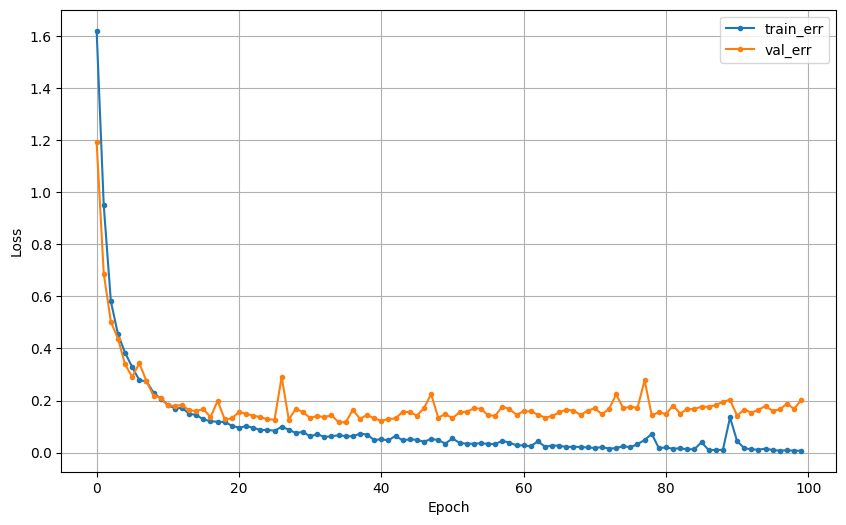

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[289   1   2]
 [  0 208  46]
 [  2   5 280]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       292
           1       0.97      0.82      0.89       254
           2       0.85      0.98      0.91       287

    accuracy                           0.93       833
   macro avg       0.94      0.93      0.93       833
weighted avg       0.94      0.93      0.93       833



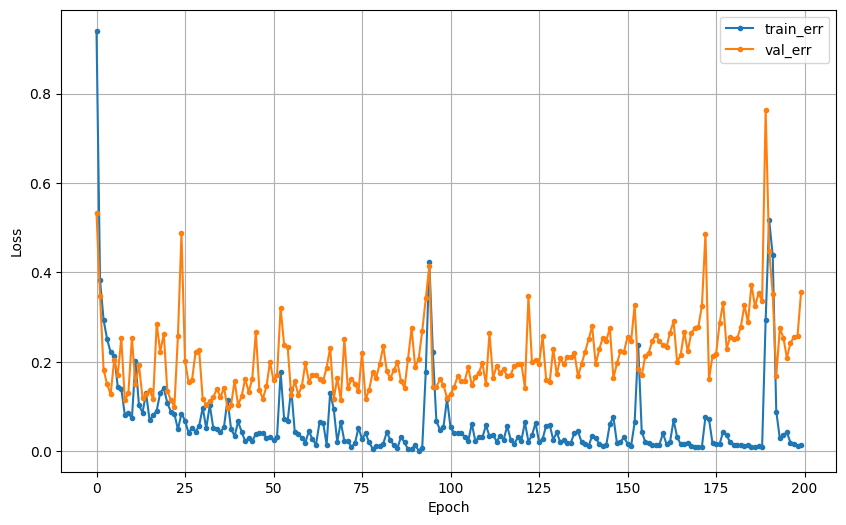

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[290   2   0]
 [  0 238  16]
 [  0  19 268]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.92      0.94      0.93       254
           2       0.94      0.93      0.94       287

    accuracy                           0.96       833
   macro avg       0.95      0.95      0.95       833
weighted avg       0.96      0.96      0.96       833



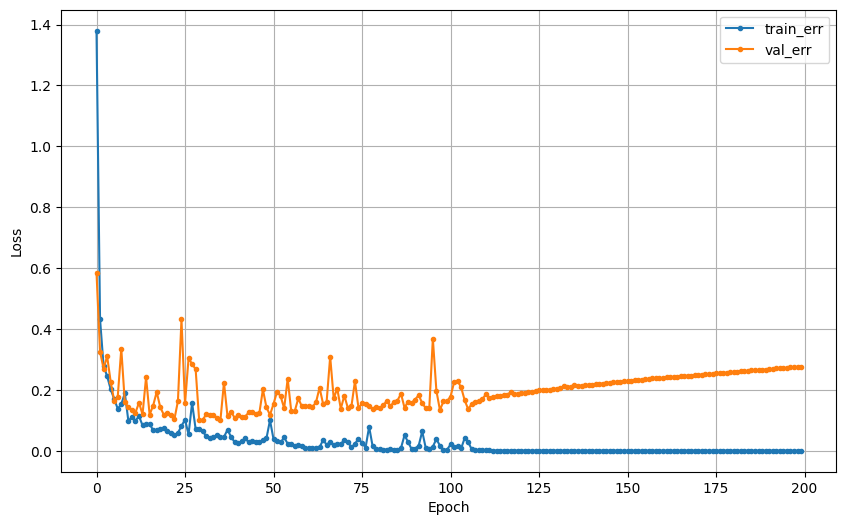

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

[[290   0   2]
 [  0 223  31]
 [  0  13 274]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.94      0.88      0.91       254
           2       0.89      0.95      0.92       287

    accuracy                           0.94       833
   macro avg       0.95      0.94      0.94       833
weighted avg       0.95      0.94      0.94       833



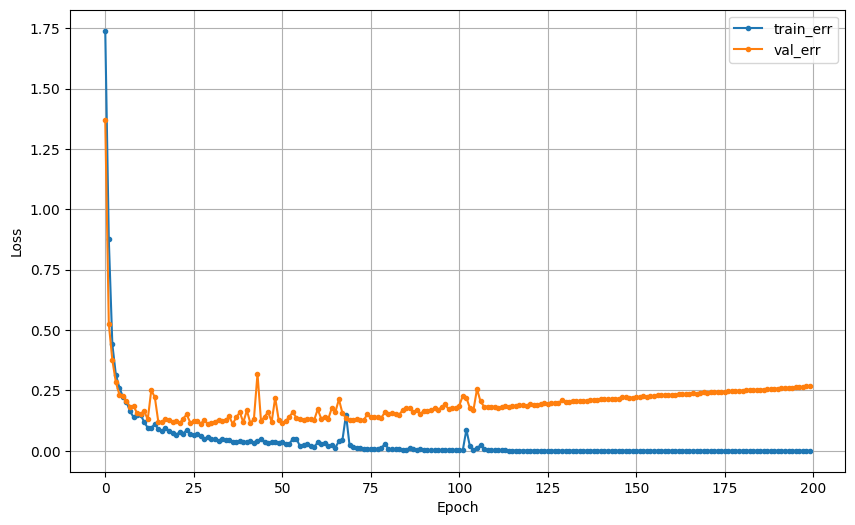

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[291   0   1]
 [  1 234  19]
 [  1  17 269]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.93      0.92      0.93       254
           2       0.93      0.94      0.93       287

    accuracy                           0.95       833
   macro avg       0.95      0.95      0.95       833
weighted avg       0.95      0.95      0.95       833



In [77]:
model2_info = hyperparameter_tuning(modeling2, x_train_static, y_train_static, x_test_static, y_test_static)

In [88]:
nfeatures = x_train_static_f.shape[1]
nfeatures

150

In [89]:
def modeling3():
  clear_session()

  drop_rate = 0.2

  model3_static = Sequential([Input(shape=(nfeatures, )),
                              Dense(128, activation='relu'),
                              Dropout(drop_rate),
                              Dense(64, activation='relu'),
                              Dropout(drop_rate),
                              Dense(32, activation='relu'),
                              Dropout(drop_rate),
                              Dense(16, activation='relu'),
                              Dropout(drop_rate),
                              Dense(8, activation='softmax')
                              ])
  return model3_static

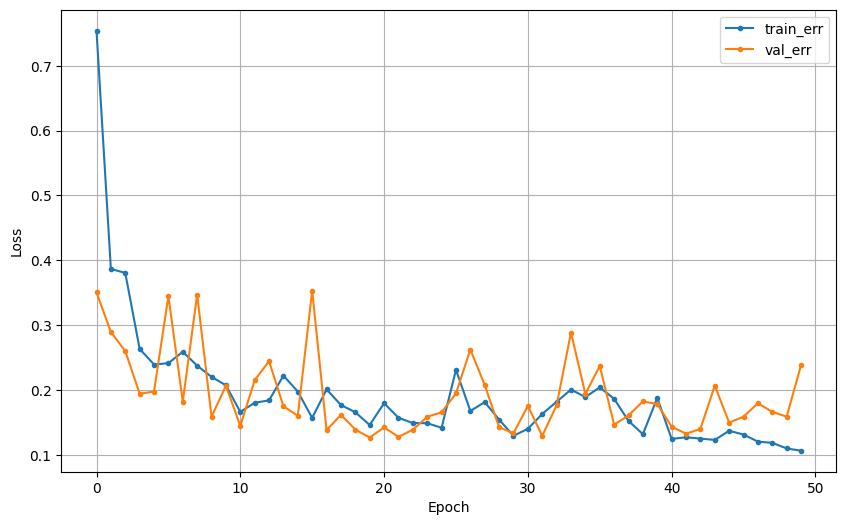

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0]
 [  0 205  49]
 [  0   5 282]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.81      0.88       254
           2       0.85      0.98      0.91       287

    accuracy                           0.94       833
   macro avg       0.94      0.93      0.93       833
weighted avg       0.94      0.94      0.93       833



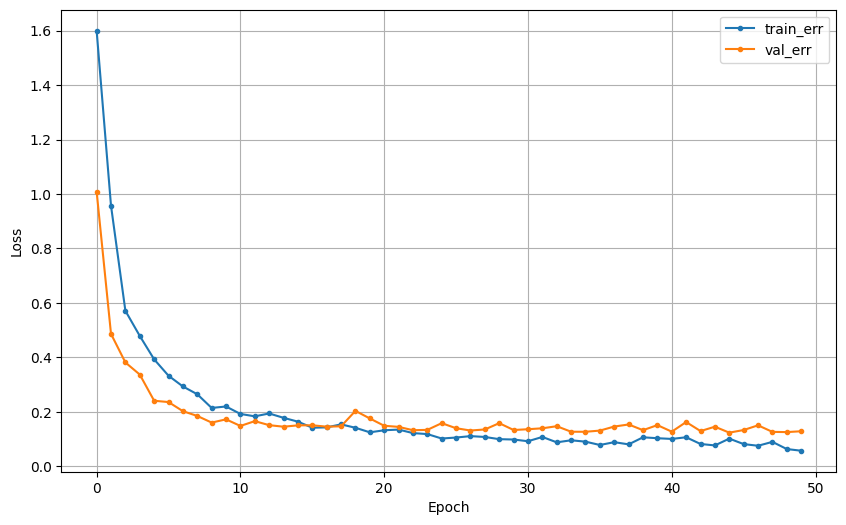

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0]
 [  0 247   7]
 [  0  10 277]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.97      0.97       254
           2       0.98      0.97      0.97       287

    accuracy                           0.98       833
   macro avg       0.98      0.98      0.98       833
weighted avg       0.98      0.98      0.98       833



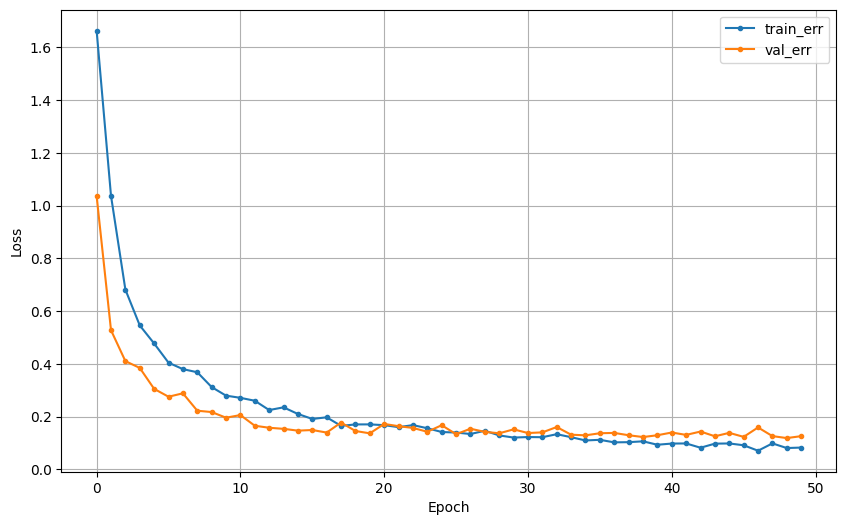

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0]
 [  2 241  11]
 [  1  12 274]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.95      0.95      0.95       254
           2       0.96      0.95      0.96       287

    accuracy                           0.97       833
   macro avg       0.97      0.97      0.97       833
weighted avg       0.97      0.97      0.97       833



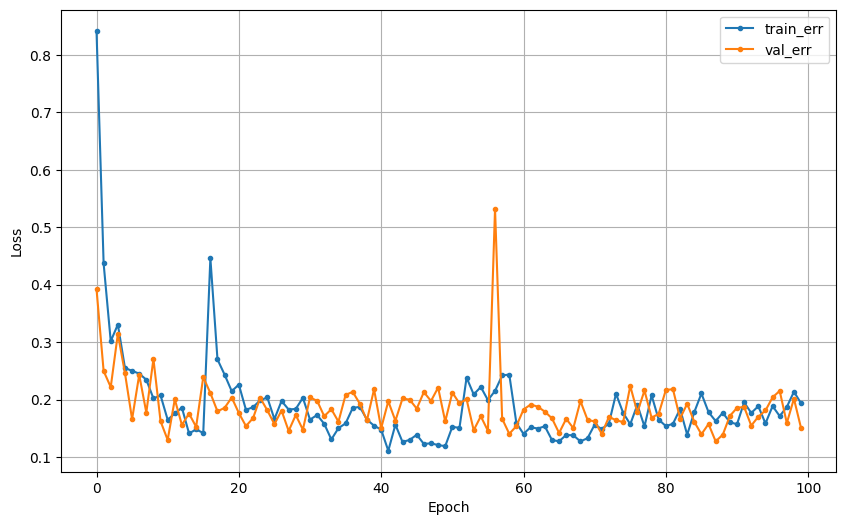

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[291   0   1]
 [  1 238  15]
 [  0  15 272]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.94      0.94      0.94       254
           2       0.94      0.95      0.95       287

    accuracy                           0.96       833
   macro avg       0.96      0.96      0.96       833
weighted avg       0.96      0.96      0.96       833



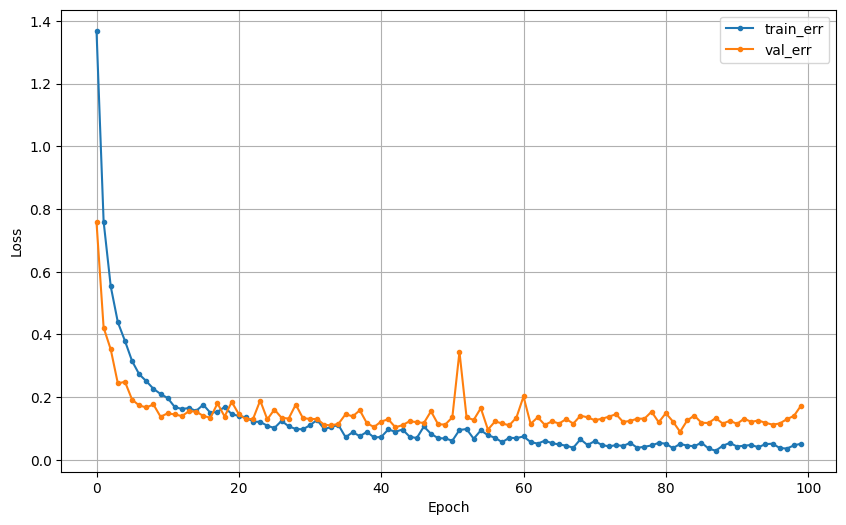

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[292   0   0]
 [  0 231  23]
 [  0   7 280]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.97      0.91      0.94       254
           2       0.92      0.98      0.95       287

    accuracy                           0.96       833
   macro avg       0.96      0.96      0.96       833
weighted avg       0.96      0.96      0.96       833



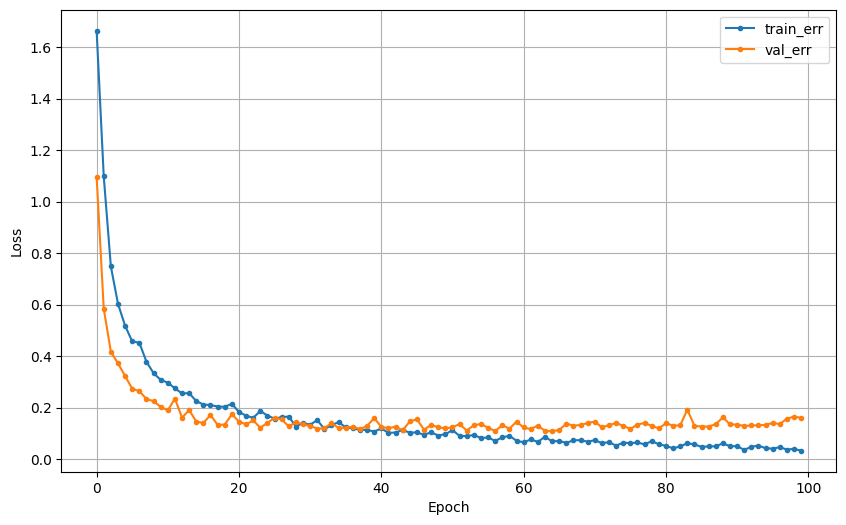

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

[[292   0   0]
 [  2 240  12]
 [  0   9 278]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       292
           1       0.96      0.94      0.95       254
           2       0.96      0.97      0.96       287

    accuracy                           0.97       833
   macro avg       0.97      0.97      0.97       833
weighted avg       0.97      0.97      0.97       833



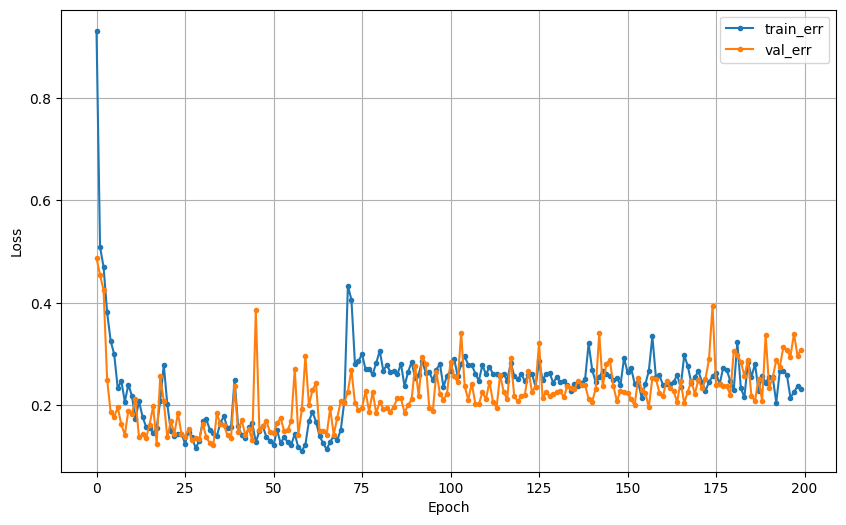

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

[[292   0   0]
 [  1 227  26]
 [  0  17 270]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.93      0.89      0.91       254
           2       0.91      0.94      0.93       287

    accuracy                           0.95       833
   macro avg       0.95      0.94      0.95       833
weighted avg       0.95      0.95      0.95       833



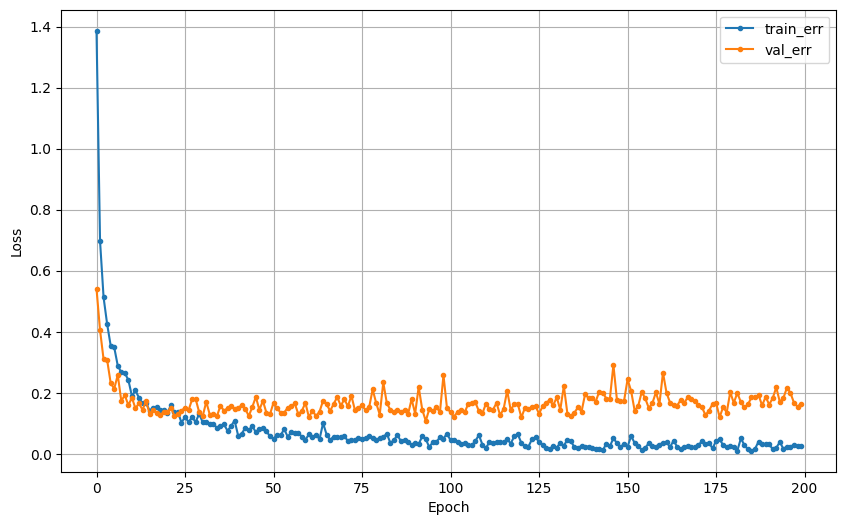

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[292   0   0]
 [  1 249   4]
 [  0  14 273]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.98      0.96       254
           2       0.99      0.95      0.97       287

    accuracy                           0.98       833
   macro avg       0.98      0.98      0.98       833
weighted avg       0.98      0.98      0.98       833



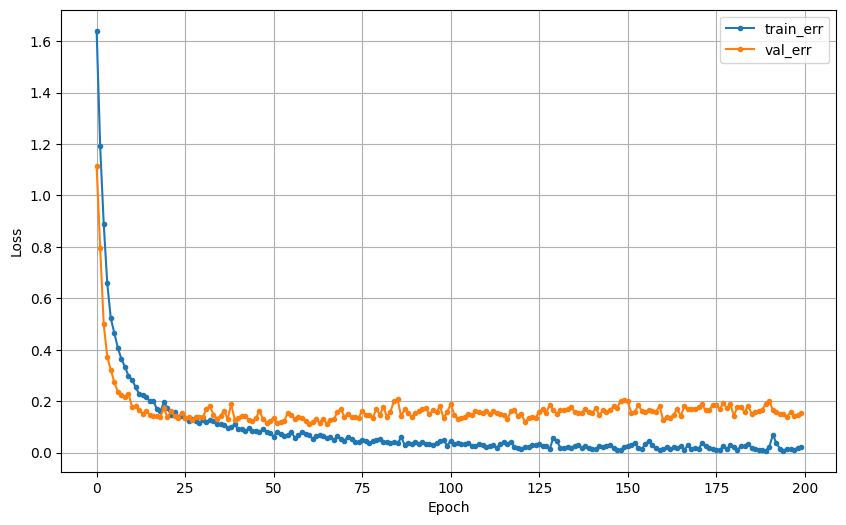

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

[[292   0   0]
 [  0 245   9]
 [  0  16 271]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.94      0.96      0.95       254
           2       0.97      0.94      0.96       287

    accuracy                           0.97       833
   macro avg       0.97      0.97      0.97       833
weighted avg       0.97      0.97      0.97       833



In [90]:
model3_info = hyperparameter_tuning(modeling3, x_train_static_f, y_train_static_f, x_test_static_f, y_test_static_f)

In [91]:
print(model3_info[1])

0.9796


#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# 정확도 그래프 시각화
def plot_accuracies_and_histories(histories, accuracy_list, avg_accuracy):
    plt.figure(figsize=(10, 6))

    # 각 반복별 정확도 그래프 그리기
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, color='blue', marker='o', linestyle='-', label='Run Accuracy')

    # 평균 정확도 표시
    plt.axhline(y=avg_accuracy, color='red', linestyle='--', label=f'Average Accuracy: {avg_accuracy:.4f}')

    # 그래프 제목, 레이블 설정
    plt.title('Accuracy for Each Run')
    plt.xlabel('Run')
    plt.ylabel('Accuracy')

    # 범례 추가
    plt.legend()

    # 그래프 출력
    plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def train_and_evaluate(model, x_train, y_train, x_val, y_val, n_repeats=5, learningrate=0.001, epoch=50):
    accuracy_list = []
    histories = []  # 각 반복의 학습 히스토리 저장

    for i in range(n_repeats):
        print(f"Training iteration {i+1} for model")
        clear_session()

        # EarlyStopping 콜백 설정
        es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=learningrate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # 모델 학습
        history = model.fit(x_train, y_train, epochs=epoch, validation_split=0.2,
                            callbacks=[es], batch_size=32, verbose=0)
        histories.append(history)  # 히스토리 저장

        # 예측 수행 및 성능 평가
        pred = model.predict(x_val)
        pred_label = np.argmax(pred, axis=1)
        accuracy = accuracy_score(y_val, pred_label)
        accuracy_list.append(accuracy)
        print(f"Accuracy for iteration {i+1}: {accuracy}")

    # 5번의 반복 수행 후 평균 성능 계산
    avg_accuracy = np.mean(accuracy_list)
    print(f"Average accuracy over {n_repeats} runs: {avg_accuracy}")

    # 성능 및 히스토리 시각화
    plot_accuracies_and_histories(histories, accuracy_list, avg_accuracy)

    return avg_accuracy

베이스

In [ ]:
nfeatures = x_train_dynamic.shape[1]
nfeatures

# Sequential 모델 설정
dynamic_base_model = Sequential([Input(shape = (nfeatures,)),
                     Dense(3, activation='softmax')])
# 모델 요약
dynamic_base_model.summary()

# 모델 5회 반복 학습 및 평가
avg_dynamic_base_model = train_and_evaluate(
    dynamic_base_model, x_train_dynamic, y_train_dynamic, x_val_dynamic, y_val_dynamic
)

상위

In [ ]:
# RandomForestClassifier로 피처 중요도 계산
rf = RandomForestClassifier(random_state=42)
rf.fit(x_dynamic_train_final, y_dynamic_train_final)

# 피처 중요도 추출
importances = rf.feature_importances_

feature_names = x_dynamic_train.columns
# 피처 이름과 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 상위, 하위 피처 선택
top_features = feature_importance_df['Feature'].head(100).tolist()
bottom_features = feature_importance_df['Feature'].tail(100).tolist()

print("상위 100개 피처:", top_features)
print("하위 100개 피처:", bottom_features)

In [ ]:
# 상위 하위 피처만 선택
selected_features1 = top_features

# 상위 피처 선택
x_train_df = pd.DataFrame(x_dynamic_train_final, columns=x_dynamic_train.columns)
x_val_df = pd.DataFrame(x_dynamic_val, columns=x_dynamic_train.columns)

# 선택한 피처들로 학습 및 검증 데이터를 생성
x_train_selected = x_train_df[selected_features1]
x_val_selected = x_val_df[selected_features1]

# Sequential 모델 설정
model4 = Sequential([
    Input(shape=(len(selected_features1),)),
    Dense(10, activation='relu'),
    Dense(7, activation='relu'),
    Dense(5, activation='relu'),
    Dense(3, activation='softmax')
])

# 모델 요약
model4.summary()

# 모델 실행
avg_accuracy_model4 = train_and_evaluate_es(
    model4, x_train_selected, y_dynamic_train_final, x_val_selected, y_dynamic_val,
    n_repeats=5, learningrate=0.001, epoch=100
)


### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
def pipeline(data_test): # 학습 데이터: data_train, 평가 데이터: data_test
    # 데이터 전처리
    data_train = pd.read_csv(path + '/data01_train.csv')
    data_train = data_train.drop(columns='subject')
    data_test = data_test.drop(columns='subject')

    data_train['is_dynamic'] = data_train['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                                                'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
    data_test['is_dynamic'] = data_test['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                                                'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})

    # 모델 1
    x_train = data_train.drop(columns='is_dynamic')
    y_train = data_train.loc[:, 'is_dynamic']
    x_test = data_test.drop(columns='is_dynamic')
    y_test = data_test.loc[:, 'is_dynamic']

    nfeatures = x_train.shape[1]
    clear_session()
    model1 = Sequential([Input(shape = (nfeatures,)),
                        Dense(200, activation='relu'),
                        Dense(50, activation='relu'),
                        Dense(1, activation='sigmoid')])
    model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
    model1.fit(x_train, y_train, epochs=100, validation_split=.2, verbose=0)

    pred = model1.predict(x_test)
    pred = np.where(pred > 0.5, 1, 0)
    # print(accuracy_score(y_test, pred))

    # final_predictions = np.zeros(len(x_test))

    # 모델 2-1 (정적)
    x_test_static = x_test[pred == 0]
    y_test_static = data_test.loc[pred == 0, 'Activity']
    if len(x_test_static) > 0:
        clear_session()

        # final_predictions[pred == 0] = static_pred

    # 모델 2-2 (동적)
    x_test_dynamic = x_test[pred == 1]
    y_test_dynamic = data_test.loc[pred == 1, 'Activity']
    if len(x_test_dynamic) > 0:
        clear_session()

        # final_predictions[pred == 1] = dynamic_pred

    # y_test_activity = data_test['Activity']
    # print("Final Combined Model Accuracy:", accuracy_score(y_test_activity, final_predictions))

# return final_predictions, accuracy_score(y_test_activity, final_predictions)

#### 2) test 셋으로 예측하고 평가하기